## Introduction: Business Problem

Bourke Street Bakery is a bakery that started in Surry Hills, Sydney, Australia offering hand made goods, catering services as well as baking classes. It has since expanded to eleven locations within the Greater Sydney area. 

The owners wish to expand their business outside of Sydney to Brisbane, Australia. This purpose of this study is to identify suburbs (i.e. neighbourhoods) in Brisbane that will be suitable for opening the first bakery. 

The suburbs where bakeries exist in Sydney will be examined and then similar suburbs in Brisbane will be identified as potential opeing locations. The primary criteria will be finding suburbs that have a similar distribution of establishments (e.g. restaurants, cafes, businesses, etc.) to those where bakeries are already established as well as considering the distance from the centre of the CBD (central business district). 


## Data

To solve the business problem the suburbs where restaurants already exist will need to be examined for any trend that link them together. When examining each suburb the following will be considered:

* Combined number of cafes and bakeries in each area
* Number and type of establishment in each area
* Proximity to the centre of the city

The following data sources will be used:

* The **geocoder** package in Python for examining geographical data of each suburb
* The **Foursquare API** for information on number of restaurants and other facilities in each suburb
* **geopy** can be used to find the distance between two locations

**Note:** This project will only consider venues in each suburb, although there are many many possibilities that could be studied.

### Initial Locations

From [Bourke St Bakery's webiste](https://bourkestreetbakery.com.au/bakery-locations/ "Bourke St Bakery Locations") we know that bakeries already exist in the following suburbs: Alexandria, Balmain, Banksmeadow, Barangaroo, Kirrawee, Marrickville, Neutral Bay, Newtown, North Sydney, Parramatta, Surry Hills and Potts Point. We can use **Folium** and **geocoder** to get a general idea of the overall location of each bakery and use that information to make any assumptions or changes in scope.

In [3]:
import numpy as np
import pandas as pd
import json
import geocoder #geographical data
with open('apikey.txt', 'r') as f:
    apikey = f.readline() # stores google apikey
from geopy.geocoders import Nominatim # convert address to latitude and longitude
import requests # handle url requests
from pandas.io.json import json_normalize # transform JSON into DataFrame
import folium # map rendering
import matplotlib.pyplot as plt
%matplotlib inline

First create a list of all the suburbs with existing bakeries

In [101]:
bakery_existing = ['Alexandria', 'Balmain', 'Banksmeadow', 'Barangaroo', 
                   'Kirrawee', 'Marrickville', 'Neutral Bay', 'Newtown', 'North Sydney', 'Parramatta',
                   'Surry Hills', 'Potts Point']

Iterate though the suburbs to find latitude and longitude, for reference Sydney's latitude and longitude is 33.8688°S, 151.2093°E, i.e. (-33.8688, 151.2093).

In [102]:
lat_exist = []
long_exist = []
#loop through suburbs
for i in bakery_existing:
    coords = None
    while(coords is None): # repeat if failed call
        g = geocoder.google('{}, Sydney, Australia'.format(i), key=apikey)
        coords = g.latlng
    lat_exist.append(coords[0])
    long_exist.append(coords[1])
    
# create a dataframe
df_existing = pd.DataFrame({'Suburb':bakery_existing, 'Latitude':lat_exist, 'Longitude':long_exist})
print(df_existing.shape)
df_existing.head()

(12, 3)


,Suburb,Latitude,Longitude
0,Alexandria,-33.908027,151.190258
1,Balmain,-33.858950,151.179060
2,Banksmeadow,-33.957310,151.206990
3,Barangaroo,-33.863794,151.202230
4,Kirrawee,-34.035730,151.070795


Now we have the suburbs' coordinates which have existing bakeries. We can visualise this with **Folium**

In [103]:
lat_lng_syd = [-33.8688, 151.2093]
# create map of Sydney
map_sydney = folium.Map(location = lat_lng_syd, zoom_start=11)
#marker for sydney
folium.Circle(color='green', radius=15000, location = lat_lng_syd).add_to(map_sydney)
folium.Circle(color='green', radius=10000, location = lat_lng_syd).add_to(map_sydney)
folium.Circle(color='green', radius=5000, location = lat_lng_syd).add_to(map_sydney)
folium.CircleMarker(
    lat_lng_syd,
    radius = 2,
    color='red',
    fill=True,
    fill_color='red').add_to(map_sydney)
#add markers for suburbs with bakeries
for lat, lng, suburb in zip(df_existing['Latitude'], df_existing['Longitude'], df_existing['Suburb']):
    label='{}'.format(suburb)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        foll_opacity=0.7,
        parse_html=False).add_to(map_sydney)
# draw a 16km diameter circle around the centre of sydney
folium.Circle(color='green', radius=15000, location = lat_lng_syd).add_to(map_sydney)
map_sydney

From the above map we can get an idea of where the bakeries (blue markers) are located to in regards to the centre of Sydney (red markers). Firstly, most are located fairly centrally with the excetion of Parramatta (west) and Kirrawee (south). 

As the majority of bakeries are located close to Sydney's CBD, we will only consider bakeries within 15km of the city (the red circle) we are left with ten of the starting twelve bakeries, with Parramatta and Kirrawee being excluded. This may mitigate other factors, such as Parramatta almost being a separate population centre, when analysing the suburbs.

In [104]:
#resulting dataframe
df_existing_15=df_existing[(df_existing['Suburb'] != 'Parramatta') & (df_existing['Suburb'] != 'Kirrawee')]
df_existing_15.reset_index(inplace=True, drop=True)
df_existing_15

,Suburb,Latitude,Longitude
0,Alexandria,-33.908027,151.190258
1,Balmain,-33.858950,151.179060
2,Banksmeadow,-33.957310,151.206990
3,Barangaroo,-33.863794,151.202230
4,Marrickville,-33.908667,151.152414
5,Neutral Bay,-33.833938,151.218846
6,Newtown,-33.897815,151.178500
7,North Sydney,-33.839650,151.205410
8,Surry Hills,-33.886111,151.211111
9,Potts Point,-33.867950,151.224110


# Location Data for Brisbane and Sydney

In this section we will collect all the location data for every suburb in Greater Sydney and Greater Brisbane. Lists of suburbs will be parsed from respective Wikipedia pages:

* [Brisbane](https://en.wikipedia.org/wiki/List_of_Brisbane_suburbs)
* [Sydney](https://en.wikipedia.org/wiki/List_of_Sydney_suburbs)

A lot of suburbs wont be considered in the analysis as they lie outside a 15km radius from each city centre. Once the list is parsed, location and distance from centre data will be generated using the **geopy** package.

In [6]:
from bs4 import BeautifulSoup
from urllib.request import urlopen # to allow opening of wikipedia page

url= r'https://en.wikipedia.org/wiki/List_of_Sydney_suburbs' #wikipedia page of Sydney suburbs
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser') # read the page
page = soup.find_all('p') #find contents of paragraphs

suburb_list_sydney = []
for para in range(5, 30): #loop through paragraphs
    suburbs = [x.contents[0] for x in page[para].find_all('a')] # get the suburb name from each link in the paragraph
    suburb_list_sydney = suburb_list_sydney + suburbs
    
df_suburbs_sydney = pd.DataFrame(columns=['suburb', 'latitude', 'longitude', 'distance']) #create dataframe
df_suburbs_sydney['suburb'] = suburb_list_sydney
print(df_suburbs_sydney.shape)
df_suburbs_sydney.head(5)

(696, 4)


,suburb,latitude,longitude,distance
0,Abbotsbury,NaN,NaN,NaN
1,Abbotsford,NaN,NaN,NaN
2,Acacia Gardens,NaN,NaN,NaN
3,Agnes Banks,NaN,NaN,NaN
4,Airds,NaN,NaN,NaN


In [7]:
url = r'https://en.wikipedia.org/wiki/List_of_Brisbane_suburbs'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
page = soup.find_all('p')

suburb_list_brisbane = []
for para in range(4, 13, 2): #loop through paragraphs
    suburbs = [x.contents[0] for x in page[para].find_all('a')]
    suburb_list_brisbane = suburb_list_brisbane + suburbs

df_suburbs_brisbane = pd.DataFrame(columns=['suburb', 'latitude', 'longitude', 'distance']) # create similar dataframe for Brisbane
df_suburbs_brisbane['suburb'] = np.sort(suburb_list_brisbane)  #sort as not in alphabetical order
print(df_suburbs_brisbane.shape)
df_suburbs_brisbane.head()

(194, 4)


,suburb,latitude,longitude,distance
0,Acacia Ridge,NaN,NaN,NaN
1,Albion,NaN,NaN,NaN
2,Alderley,NaN,NaN,NaN
3,Algester,NaN,NaN,NaN
4,Annerley,NaN,NaN,NaN


#### Function to apply to dataframes for location and distance

In [60]:
from geopy import distance # calculate distance between two locations

#geocoder.google('{}, Australia'.format(location), key=apikey)#add longitude and latitude
#lat_lng = [-33.8688, 151.2093] # latitude and longitude of sydney
city_coords = {'Brisbane': geocoder.google('Brisbane, Australia', key=apikey).latlng,
               'Sydney':geocoder.google('Sydney, Australia', key=apikey).latlng} #coordinates of each city centre

def long_lat(row, location):
    """location should be Brisbane or Sydney"""
    coords = None
    #print(row['suburb'])
    while(coords is None):
        g = geocoder.google('{}, {}, Australia'.format(location, row['suburb']), key=apikey) 
        coords = g.latlng #coordinates of each suburb
    lat = coords[0]
    lng = coords[1]
    row['latitude'] = lat
    row['longitude'] = lng
    row['distance'] = distance.distance(coords, city_coords[location]).km #calulate distance
    return row
print(city_coords)

{'Brisbane': [-27.4697707, 153.0251235], 'Sydney': [-33.8688197, 151.2092955]}


Cell below applies the above function to each dataframe, currently it is commented so I don't have to call geocoder all the time. Suburb data is in csv files which are saved a few cells later.

In [13]:
df_suburbs_brisbane.apply(long_lat, args=['Brisbane'], axis=1)
df_suburbs_sydney.apply(long_lat, args=['Sydney'], axis=1)

,suburb,latitude,longitude,distance
0,Abbotsbury,-33.87500,150.86200,32.140195
1,Abbotsford,-33.85215,151.12726,7.813137
2,Acacia Gardens,-33.73220,150.91700,31.019911
3,Agnes Banks,-33.61529,150.71616,53.654920
4,Airds,-34.09160,150.82490,43.270640
...,...,...,...,...
691,Yarramundi,-33.62220,150.67090,56.894698
692,Yarrawarrah,-34.05520,151.03210,26.374588
693,Yennora,-33.86270,150.96600,22.522324
694,Yowie Bay,-34.04977,151.10334,22.333085


In [351]:
# we should also drop duplicate rows (e.g. Sinnamon Park in Brisbane occurs twice)
df_suburbs_brisbane.drop_duplicates(inplace=True)
df_suburbs_sydney.drop_duplicates(inplace=True)

In [190]:
# save dataframes to csv just to not have to call geopy.google 1000 times again
# df_suburbs_brisbane.to_csv('brisbane_suburbs_with_location.csv')
# df_suburbs_sydney.to_csv('sydney_suburbs_with_location.csv')
# read csv files if needed
df_suburbs_brisbane = pd.read_csv('brisbane_suburbs_with_location.csv', index_col=0)
df_suburbs_sydney = pd.read_csv('sydney_suburbs_with_location.csv', index_col=0)

Now we have a list of all the suburbs in Brisbane and Sydney. They can be visualised with **Folium** where red markers are suburbs within 15km of the city centre and blue markers are outside a 15km radius.

### Sydney map

In [192]:
# create map of Sydney
map_sydney = folium.Map(location = city_coords['Sydney'], zoom_start=10)
#marker for sydney
folium.CircleMarker( #centre of sydney marker
    city_coords['Sydney'],
    radius = 2,
    color='red',
    fill=True,
    fill_color='red').add_to(map_sydney)
#add markers for suburbs with bakeries
for lat, lng, suburb, distance in zip(df_suburbs_sydney['latitude'], df_suburbs_sydney['longitude'],
                                      df_suburbs_sydney['suburb'], df_suburbs_sydney['distance']):
    label='{}'.format(suburb)
    #label = folium.Popup(label, parse_html=True)
    if distance <= 15:
        mark_color = 'red'
    else:
        mark_color='blue'
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=2,
        tooltip=label,
        color=mark_color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)
# draw a 15km radius circle around the centre of sydney
folium.Circle(color='green', radius=15000, location = city_coords['Sydney']).add_to(map_sydney)
map_sydney

In [193]:
# create map of Brisbane
map_brisbane = folium.Map(location = city_coords['Brisbane'], zoom_start=11)
#marker for sydney
folium.CircleMarker( #centre of sydney marker
    city_coords['Brisbane'],
    radius = 2,
    color='red',
    fill=True,
    fill_color='red').add_to(map_brisbane)
#add markers for suburbs with bakeries
for lat, lng, suburb, distance in zip(df_suburbs_brisbane['latitude'], df_suburbs_brisbane['longitude'],
                                      df_suburbs_brisbane['suburb'], df_suburbs_brisbane['distance']):
    label='{}'.format(suburb)
    #label = folium.Popup(label, parse_html=True)
    if distance <= 15: # cehck what colour to make the marker
        mark_color = 'red'
    else:
        mark_color='blue'
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=2,
        tooltip=label,
        color=mark_color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)
# draw a 15km radius circle around the centre of sydney
folium.Circle(color='green', radius=15000, location = city_coords['Brisbane']).add_to(map_brisbane)
map_brisbane

## Foursquare data for each suburb

This section will focus on using the **Foursquare** API to retrieve data of facilities in each suburb and preparing the data for use with a clustering model.

In [356]:
# get foursquare credentials
with open('foursquare_credentials.txt') as f:
    l = f.readline()
    fs_cred = json.loads(l)
client_id = fs_cred['CLIENT_ID']
client_secret = fs_cred['CLIENT_SECRET']
access_token = fs_cred['ACCESS_TOKEN']
version = fs_cred['VERSION']

We will use a radius of 1000m when searching each suburb. Each suburb is a different size and shape so this wont be the most ideal approach, but for the purpose of this analysis it should be adequate. It is expected that there will be some overlap between neighbouring suburbs but this may still capture venues in the vicinity of a suburb well enough for the purpose of this notebook. The limit is set to 100 as that is the limit allowed with the level of access I have to Foursquare.

In [357]:
radius = '1000' # radius of search area
limit = '100' # limit number of returns

Now reduce size of the suburb dataframes to only include suburbs within a 15km radius of the city centre

In [358]:
df_suburbs_brisbane_15 = df_suburbs_brisbane[df_suburbs_brisbane['distance'] <= 15]
df_suburbs_sydney_15 = df_suburbs_sydney[df_suburbs_sydney['distance'] <= 15]
df_suburbs_brisbane_15.reset_index(drop=True, inplace=True)
df_suburbs_sydney_15.reset_index(drop=True, inplace=True)
print(df_suburbs_brisbane_15.shape)
print(df_suburbs_sydney_15.shape)

(152, 4)
(249, 4)


In [366]:
# url that can be used for foursquare searchs
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&oauth_token={}&ll={},{},&v={}&radius={}&limit={}'
print(url)

https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&oauth_token={}&ll={},{},&v={}&radius={}&limit={}


For the above url, just need *client id*, *client secret*, *auth token*, *longitude* and *latitude*, *version*, *radius* and *limit*.

In [380]:
def run_foursquare(df):
    """ runs foursquare requests, df is dataframe of suburbs, should have a coloumn named 'latitude' and 'longitude'"""
    venue_list = []
    for index, row in df.iterrows(): #iterate through rows of dataframe
        #print(row['suburb'])
        lat = row['latitude']
        long = row['longitude']
        url_full = url.format(client_id, client_secret, access_token, str(lat), str(long), version, radius, limit) # fill in values of url
        #print(url_full)
        results = requests.get(url_full).json() # calls foursquare
        items = results['response']['groups'][0]['items'] #get venues from json structure
        #only interested in the suburb details and venue details so will append this to venue_list
        venue_list.append([(row['suburb'], row['latitude'], row['longitude'], row['distance'], item['venue']['name'], item['venue']['categories'][0]['name']) for item in items])
    return venue_list

In [620]:
venues_brisbane = run_foursquare(df_suburbs_brisbane_15)

In [621]:
venues_sydney = run_foursquare(df_suburbs_sydney_15)

We now have two lists where each item in the list is a list of venues within a suburb, the information can be stored in a dataframe.

In [622]:
df_venues_sydney = pd.DataFrame([item for items in venues_sydney for item in items], columns = ['Suburb', 'Latitude', 'Longitude', 'Distance', 'Venue_Name', 'Venue_Type'])
print(df_venues_sydney.shape)
df_venues_sydney.head()

(12164, 6)


,Suburb,Latitude,Longitude,Distance,Venue_Name,Venue_Type
0,Abbotsford,-33.85215,151.12726,7.813137,The Cove Dining Co,Café
1,Abbotsford,-33.85215,151.12726,7.813137,The Cove Dining Co,Café
2,Abbotsford,-33.85215,151.12726,7.813137,Sydney Rowing Club,Sports Club
3,Abbotsford,-33.85215,151.12726,7.813137,Orchid Thai,Thai Restaurant
4,Abbotsford,-33.85215,151.12726,7.813137,Watergrill,Australian Restaurant


In [623]:
df_venues_brisbane = pd.DataFrame([item for items in venues_brisbane for item in items], columns = ['Suburb', 'Latitude', 'Longitude', 'Distance', 'Venue_Name', 'Venue_Type'])
print(df_venues_brisbane.shape)
df_venues_brisbane.head()

(4450, 6)


,Suburb,Latitude,Longitude,Distance,Venue_Name,Venue_Type
0,Acacia Ridge,-27.583333,153.033333,12.610156,Subway,Sandwich Place
1,Acacia Ridge,-27.583333,153.033333,12.610156,IGA Acacia Ridge,Grocery Store
2,Acacia Ridge,-27.583333,153.033333,12.610156,KFC,Fast Food Restaurant
3,Acacia Ridge,-27.583333,153.033333,12.610156,Cairncross Radiators Australia Pty Ltd,Auto Garage
4,Acacia Ridge,-27.583333,153.033333,12.610156,Nutrien Ag Solutions,Farm


From Foursquare data, there are 12164 venues in Sydney and 4483 venues in Brisbane. 

In [4]:
#df_venues_brisbane.to_csv('venues_brisbane.csv')
#df_venues_sydney.to_csv('venues_sydney.csv')
df_venues_brisbane=pd.read_csv('venues_brisbane.csv', index_col=0)
df_venues_sydney=pd.read_csv('venues_sydney.csv', index_col=0)

In [5]:
df_venues_brisbane.groupby('Suburb').count()

,Latitude,Longitude,Distance,Venue_Name,Venue_Type
Suburb,,,,,
Acacia Ridge,8,8,8,8,8
Albion,38,38,38,38,38
Alderley,20,20,20,20,20
Annerley,35,35,35,35,35
Archerfield,14,14,14,14,14
...,...,...,...,...,...
Wynnum,29,29,29,29,29
Wynnum West,22,22,22,22,22
Yeerongpilly,16,16,16,16,16


In [6]:
df_venues_sydney.groupby('Suburb').count()

,Latitude,Longitude,Distance,Venue_Name,Venue_Type
Suburb,,,,,
Abbotsford,28,28,28,28,28
Alexandria,86,86,86,86,86
Allambie Heights,12,12,12,12,12
Allawah,16,16,16,16,16
Angus,100,100,100,100,100
...,...,...,...,...,...
Wollstonecraft,23,23,23,23,23
Woollahra,100,100,100,100,100
Woolloomooloo,100,100,100,100,100


It should be noted that there is one less row in the Sydney dataframe compared to the brisbane dataframe. This suggests that a foursquare enquiry has returned zero results.

In [7]:
print('There are {} unique venues in Brisbane'.format(len(df_venues_brisbane['Venue_Type'].unique())))
print('There are {} unique venues in Sydney'.format(len(df_venues_sydney['Venue_Type'].unique())))

There are 300 unique venues in Brisbane
There are 395 unique venues in Sydney


Now that we have two dataframes (one for Sydney and one for Brisbane), we can perform one hot encoding to identify venue types in each suburb.

In [8]:
df_venues_brisbane_one_hot = pd.get_dummies(df_venues_brisbane[['Venue_Type']], prefix="", prefix_sep="")
df_venues_sydney_one_hot = pd.get_dummies(df_venues_sydney[['Venue_Type']], prefix="", prefix_sep="")
print(df_venues_brisbane_one_hot.shape)
print(df_venues_sydney_one_hot.shape)

(4450, 300)
(12164, 395)


In [9]:
# We want to merge columns for Cafe and Coffee Shop for both cities

df_venues_sydney_one_hot[['Café']] = df_venues_sydney_one_hot.loc[:, ['Café', 'Coffee Shop']].sum(axis=1) #sum the two columns together
df_venues_sydney_one_hot.drop('Coffee Shop', axis=1, inplace=True) #remove the coffee shop column
df_venues_brisbane_one_hot[['Café']] = df_venues_brisbane_one_hot.loc[:, ['Café', 'Coffee Shop']].sum(axis=1)
df_venues_brisbane_one_hot.drop('Coffee Shop', axis=1, inplace=True)

In [10]:
# Will also merge pub, bar and sports bar
df_venues_sydney_one_hot[['Pub']] = df_venues_sydney_one_hot.loc[:,['Pub','Bar','Sports Bar']].sum(axis=1)
df_venues_sydney_one_hot.drop(['Bar','Sports Bar'],axis=1, inplace=True)
df_venues_brisbane_one_hot[['Pub']] = df_venues_brisbane_one_hot.loc[:,['Pub','Bar']].sum(axis=1)
df_venues_brisbane_one_hot.drop(['Bar'],axis=1, inplace=True)

In [11]:
# now concatenate the one_hot dataframe with the suburb dataframe
df_venues_brisbane_final = pd.concat([df_venues_brisbane, df_venues_brisbane_one_hot], axis=1)
# group by suburbs taking the average to find frequency of occurence
df_venues_brisbane_avg = df_venues_brisbane_final.groupby('Suburb', axis=0).mean().reset_index()
df_venues_brisbane_avg.head()

,Suburb,Latitude,Longitude,Distance,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Alternative Healer,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Acacia Ridge,-27.583333,153.033333,12.610156,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Albion,-27.431944,153.046111,4.676972,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alderley,-27.423889,153.005000,5.459541,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Annerley,-27.513896,153.030935,4.923210,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Archerfield,-27.568333,153.024167,10.922269,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# repeat the process for sydney
df_venues_sydney_final = pd.concat([df_venues_sydney, df_venues_sydney_one_hot], axis=1)
# group by suburbs taking the average to find frequency of occurence
df_venues_sydney_avg = df_venues_sydney_final.groupby('Suburb', axis=0).mean().reset_index()
df_venues_sydney_avg.head()

,Suburb,Latitude,Longitude,Distance,Accessories Store,Adult Boutique,Advertising Agency,Airfield,Alternative Healer,American Restaurant,...,Vietnamese Restaurant,Vineyard,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Abbotsford,-33.852150,151.127260,7.813137,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.071429,0.0,0.0,0.0,0.0
1,Alexandria,-33.908027,151.190258,4.691974,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.023256,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
2,Allambie Heights,-33.762400,151.250000,12.390964,0.0,0.0,0.0,0.0,0.0,0.083333,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
3,Allawah,-33.974900,151.116700,14.552084,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
4,Angus,-33.863379,151.208151,0.612704,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.0


For clustering, the distance column will need to be scaled. It will be scaled using the StandardScalar function from sklearn.preprocessing and the results will be a mean of zero and a variance of one.

In [13]:
from sklearn.preprocessing import StandardScaler
scalar1 = StandardScaler()
bris_dist = scalar1.fit(df_venues_brisbane_avg[['Distance']]).transform(df_venues_brisbane_avg[['Distance']])
scalar2 = StandardScaler()
syd_dist = scalar1.fit(df_venues_sydney_avg[['Distance']]).transform(df_venues_sydney_avg[['Distance']])

In [14]:
df_venues_sydney_avg[['Distance']] = syd_dist
df_venues_sydney_avg.head()

,Suburb,Latitude,Longitude,Distance,Accessories Store,Adult Boutique,Advertising Agency,Airfield,Alternative Healer,American Restaurant,...,Vietnamese Restaurant,Vineyard,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Abbotsford,-33.852150,151.127260,-0.079118,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.071429,0.0,0.0,0.0,0.0
1,Alexandria,-33.908027,151.190258,-0.848824,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.023256,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
2,Allambie Heights,-33.762400,151.250000,1.049814,0.0,0.0,0.0,0.0,0.0,0.083333,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
3,Allawah,-33.974900,151.116700,1.582765,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
4,Angus,-33.863379,151.208151,-1.854808,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.0


In [15]:
df_venues_brisbane_avg[['Distance']] = bris_dist
df_venues_brisbane_avg.head()

,Suburb,Latitude,Longitude,Distance,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Alternative Healer,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Acacia Ridge,-27.583333,153.033333,1.059961,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Albion,-27.431944,153.046111,-0.910176,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alderley,-27.423889,153.005000,-0.715832,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Annerley,-27.513896,153.030935,-0.849025,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Archerfield,-27.568333,153.024167,0.640789,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering the Suburb Data

At this point we now have two dataframes, one for Sydney and one for Brisbane. In the next section a clustering model will be created and clusters will be created using the data of Sydney suburbs and predictions will be made using Brisbane suburbs. 

In [16]:
from sklearn.cluster import KMeans # import K-means clustering module

In [17]:
sydney_cluster_data = df_venues_sydney_avg.drop(['Suburb', 'Latitude', 'Longitude'], 1)

In [18]:
# First have to consider the mismatch in columns
brisbane_cluster_data = df_venues_brisbane_avg.drop(['Suburb', 'Latitude', 'Longitude'], 1)
bris_columns = set(brisbane_cluster_data.columns)
syd_columns = set(sydney_cluster_data.columns)
col_to_add = syd_columns - bris_columns
col_to_add

{'Adult Boutique',
 'Advertising Agency',
 'Airfield',
 'Antique Shop',
 'Aquarium',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Museum',
 'Arts & Entertainment',
 'Austrian Restaurant',
 'Badminton Court',
 'Baseball Stadium',
 'Basketball Stadium',
 'Bay',
 'Beach Bar',
 'Beijing Restaurant',
 'Belgian Restaurant',
 'Betting Shop',
 'Bike Rental / Bike Share',
 'Bridal Shop',
 'Bridge',
 'Building',
 'Butcher',
 'Car Wash',
 'Caribbean Restaurant',
 'Cave',
 'Cemetery',
 'Cha Chaan Teng',
 'Chaat Place',
 'Cheese Shop',
 'Child Care Service',
 'Chiropractor',
 'Church',
 'Churrascaria',
 'Coffee Roaster',
 'College Rec Center',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Currency Exchange',
 'Dam',
 'Distillery',
 'Dive Shop',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Falafel Restaurant',
 'Field',
 'Filipino Restaurant',
 'Film Studio',
 'Financial or Legal Service',
 'Food Service',
 'Fountain',
 'General College & Universit

A quick scan though the venue types that are in Sydney but not in Brisbane suggest that some discrepancies occur due to fairly minor details. For example, a restaurant labelled as a Hunan restaurant in Sydney, may appear as a Chinese restaurant in Brisbane. We can check the significance of the different labels by looking at the quantity in the Sydney Dataframe. We will assume that occurence frequencies larger than 10% should be considered. The reverse, venues in Brisbane but not Sydney should also be considered.

In [19]:
high_freq_venues=sydney_cluster_data.loc[:, list(col_to_add)].max() > 0.1 #venue types that have more than 10% occurence in a suburb
high_freq_venues = high_freq_venues[high_freq_venues == True]
high_freq_venues

River                 True
Tour Provider         True
Summer Camp           True
Swim School           True
Surf Spot             True
Dam                   True
Tailor Shop           True
Child Care Service    True
dtype: bool

As this project focusses on the expansion of a bakery, only the venue type of 'sports bar' will be considered as influential, with all other types not having a high enough frequency or the types not being particularly relevant to a bakery.

In [20]:
# want dataframes only with data to enter into clustering model (so need to drop Suburb, Longitide and Latitude columns)
sydney_cluster_data = df_venues_sydney_avg.drop(['Suburb', 'Latitude', 'Longitude'], 1)

In [21]:
# Now do the reverse
col_to_add = bris_columns - syd_columns
high_freq_venues=brisbane_cluster_data.loc[:, list(col_to_add)].max() > 0.1 #venue types that have more than 10% occurence in a suburb
high_freq_venues = high_freq_venues[high_freq_venues == True]
high_freq_venues

Exhibit            True
Airport Service    True
Zoo                True
Airport            True
Airport Lounge     True
Mobility Store     True
Farm               True
dtype: bool

After checking high frequency venues in Brisbane but not in Sydney, a similar conclusion that the listed venues probably do not influence the location of a bakery. Thus no changes to the data in the Brisbane DataFrame will be made.

In [22]:
# repeat the process of finding excess columns
bris_columns = set(brisbane_cluster_data.columns)
syd_columns = set(sydney_cluster_data.columns)
col_to_add = syd_columns - bris_columns
col_to_add

{'Adult Boutique',
 'Advertising Agency',
 'Airfield',
 'Antique Shop',
 'Aquarium',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Museum',
 'Arts & Entertainment',
 'Austrian Restaurant',
 'Badminton Court',
 'Baseball Stadium',
 'Basketball Stadium',
 'Bay',
 'Beach Bar',
 'Beijing Restaurant',
 'Belgian Restaurant',
 'Betting Shop',
 'Bike Rental / Bike Share',
 'Bridal Shop',
 'Bridge',
 'Building',
 'Butcher',
 'Car Wash',
 'Caribbean Restaurant',
 'Cave',
 'Cemetery',
 'Cha Chaan Teng',
 'Chaat Place',
 'Cheese Shop',
 'Child Care Service',
 'Chiropractor',
 'Church',
 'Churrascaria',
 'Coffee Roaster',
 'College Rec Center',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Currency Exchange',
 'Dam',
 'Distillery',
 'Dive Shop',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Falafel Restaurant',
 'Field',
 'Filipino Restaurant',
 'Film Studio',
 'Financial or Legal Service',
 'Food Service',
 'Fountain',
 'General College & Universit

In [23]:
# add excess columns to the brisbane dataframe and fill NaN values to 0 (i.e. no venues)
df_venues_brisbane_avg_extra = pd.concat([df_venues_brisbane_avg, pd.DataFrame(columns=list(col_to_add))], axis=1).fillna(0)
brisbane_cluster_data = df_venues_brisbane_avg_extra.drop(['Suburb', 'Latitude', 'Longitude'], 1)
#need to reorder the columns
col = list(brisbane_cluster_data.columns[1:].values)
col.sort()
brisbane_cluster_data = pd.concat([brisbane_cluster_data[['Distance']], brisbane_cluster_data[col]], axis=1)
brisbane_cluster_data.head()

,Distance,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,Airfield,Airport,Airport Lounge,Airport Service,Alternative Healer,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,1.059961,0.0,0,0,0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,-0.910176,0.0,0,0,0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,-0.715832,0.0,0,0,0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,-0.849025,0.0,0,0,0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,0.640789,0.0,0,0,0.0,0,0.142857,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [24]:
# Repeat the process for Sydney
col_to_add = bris_columns- syd_columns
# add excess columns to the sydney dataframe and fill NaN values to 0 (i.e. no venues)
df_venues_sydney_avg_extra = pd.concat([df_venues_sydney_avg, pd.DataFrame(columns=list(col_to_add))], axis=1).fillna(0)
sydney_cluster_data = df_venues_sydney_avg_extra.drop(['Suburb', 'Latitude', 'Longitude'], 1)
#need to reorder the columns
col = list(sydney_cluster_data.columns[1:].values)
col.sort()
sydney_cluster_data = pd.concat([sydney_cluster_data[['Distance']], sydney_cluster_data[col]], axis=1)
sydney_cluster_data.head()

,Distance,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,Airfield,Airport,Airport Lounge,Airport Service,Alternative Healer,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,-0.079118,0.0,0.0,0.0,0,0.0,0,0,0,0.0,...,0,0.0,0.00,0.0,0.071429,0.0,0.0,0.0,0.0,0
1,-0.848824,0.0,0.0,0.0,0,0.0,0,0,0,0.0,...,0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,1.049814,0.0,0.0,0.0,0,0.0,0,0,0,0.0,...,0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0
3,1.582765,0.0,0.0,0.0,0,0.0,0,0,0,0.0,...,0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,-1.854808,0.0,0.0,0.0,0,0.0,0,0,0,0.0,...,0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0


Before clustering the suburbs in Sydney, the optimum number of clusters needs to be found. This can be done by iterating through some values of k and then applying the elbow method.

In [39]:
k_max = 10
wss = []
for i in range(2, k_max+1):
    kmeans_eval = KMeans(n_clusters=i, random_state=0).fit(sydney_cluster_data) #create and fit data to model
    wss.append(kmeans_eval.inertia_) #append in cluster sum of squares
    

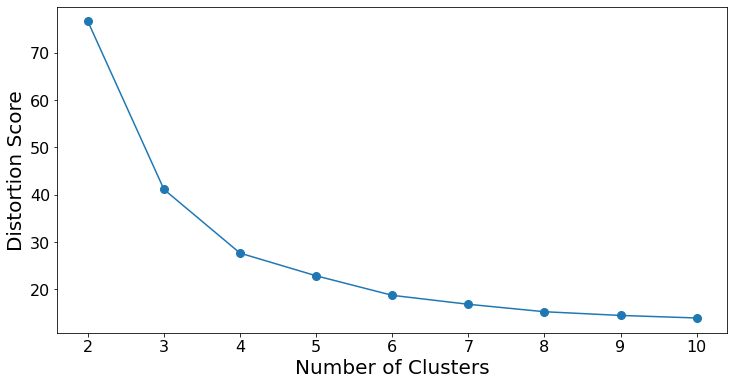

In [52]:
#Now plot sum of squares against value of k
fig=plt.figure(figsize=[12,6])
ax = fig.gca()
ax.plot(np.arange(2, k_max+1), wss, marker='.', ms=16)
ax.set_xlabel('Number of Clusters', fontsize=20)
ax.set_ylabel('Distortion Score', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.savefig('distortion_score_distance.png')

From the plot above we can see that the optimum number of clusters to use is either 4 or 5. We will go with 5 clusters for now.

In [56]:
kclusters=5
# now create the kmeans clustering model
kmeans = KMeans(n_clusters = kclusters, random_state =0).fit(sydney_cluster_data) #create the clustering model and fit to the sydney venue data
# We can now merge the labels with the original dataframe
syd_clusters = df_venues_sydney_avg[['Suburb','Latitude','Longitude','Distance']]
syd_clusters.insert(0, 'Labels', kmeans.labels_)
syd_clusters.head()

,Labels,Suburb,Latitude,Longitude,Distance
0,4,Abbotsford,-33.852150,151.127260,-0.079118
1,3,Alexandria,-33.908027,151.190258,-0.848824
2,2,Allambie Heights,-33.762400,151.250000,1.049814
3,2,Allawah,-33.974900,151.116700,1.582765
4,0,Angus,-33.863379,151.208151,-1.854808


In [57]:
#now we can apply the model to the Brisbane Data
brisbane_clustering = kmeans.predict(brisbane_cluster_data)
brisbane_clusters = df_venues_brisbane_avg[['Suburb','Latitude','Longitude','Distance']]
brisbane_clusters.insert(0, 'Labels', brisbane_clustering)
brisbane_clusters.head()

,Labels,Suburb,Latitude,Longitude,Distance
0,2,Acacia Ridge,-27.583333,153.033333,1.059961
1,3,Albion,-27.431944,153.046111,-0.910176
2,3,Alderley,-27.423889,153.005000,-0.715832
3,3,Annerley,-27.513896,153.030935,-0.849025
4,1,Archerfield,-27.568333,153.024167,0.640789


Now we have two sets of labels for both citys, we can begin comparing the data.

## The results

This will be the final section where we compare suburb labels between the two cities and see what the best location to open a new bakery in Brisbane will be. First off, we will visualise the clusters with Folium.

#### Sydney Clusters

In [61]:
# create map of Sydney
map_sydney = folium.Map(location = city_coords['Sydney'], zoom_start=11)
colours = ['red','blue','green','purple','orange', 'pink', 'black', 'gray']
for label, suburb, lat, lng in zip(syd_clusters['Labels'], syd_clusters['Suburb'],
                                      syd_clusters['Latitude'], syd_clusters['Longitude']):
    suburb_label='{}:, {}'.format(suburb, label)
    #label = folium.Popup(label, parse_html=True)
    mark_colour = colours[label]
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=2,
        tooltip=suburb_label,
        color=mark_colour,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)
map_sydney

In [165]:
# create map of Brisbane
map_brisbane = folium.Map(location = city_coords['Brisbane'], zoom_start=11)
colours = ['red','blue','green','purple','orange', 'pink', 'black', 'gray']
for label, suburb, lat, lng in zip(brisbane_clusters['Labels'], brisbane_clusters['Suburb'],
                                      brisbane_clusters['Latitude'], brisbane_clusters['Longitude']):
    suburb_label='{}:, {}'.format(suburb, label)
    #label = folium.Popup(label, parse_html=True)
    mark_colour = colours[label]
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=2,
        tooltip=suburb_label,
        color=mark_colour,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)
map_brisbane

When examining the results of the clustering, it appears that the clusters are determined largely by proximity to the city centre.

In [106]:
syd_clusters.set_index('Suburb').loc[df_existing_15.Suburb].groupby('Labels').count()

,Latitude,Longitude,Distance
Labels,,,
0,3,3,3
1,1,1,1
3,5,5,5
4,1,1,1


The most popular cluster label for existing bakeries is 3, followed by 0 and 1 which are increasing with distance from the city centre. It would be interesting to see the results if distance was removed from the clustering model.

In [64]:
bris_no_distance = brisbane_cluster_data.drop('Distance', axis=1) #drop distance
syd_no_distance = sydney_cluster_data.drop('Distance', axis=1) #drop distance

We can also run multiple numbers of clusters again to find the optimal number of clusters for the new dataset.

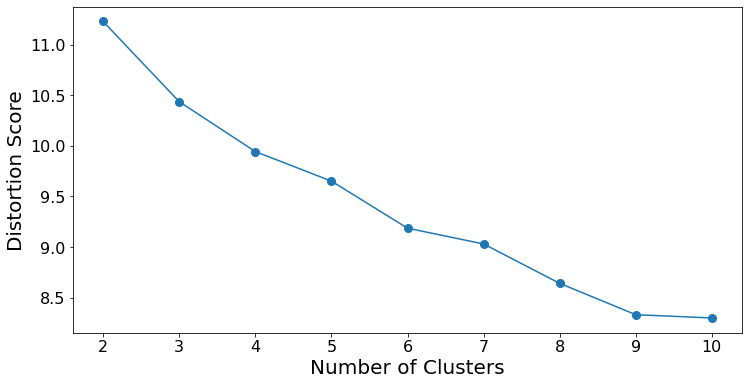

In [157]:
k_max = 10
wss = []
for i in range(2, k_max+1):
    kmeans_eval = KMeans(n_clusters=i, random_state=0).fit(syd_no_distance) #create and fit data to model
    wss.append(kmeans_eval.inertia_) #append in cluster sum of squares
#Now plot sum of squares against value of k
fig=plt.figure(figsize=[12,6])
ax = fig.gca()
ax.plot(np.arange(2, k_max+1), wss, marker='.', ms=16)
ax.set_xlabel('Number of Clusters', fontsize=20)
ax.set_ylabel('Distortion Score', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.savefig('distortion_score_n0_distance.png')  

Here it is less obivous what cluster number to use. To keep similarity with the previous study, 5 clusters will be used again

In [66]:
kclusters=5
kmeans = KMeans(n_clusters = kclusters, random_state =0).fit(syd_no_distance)
syd_clusters_2 = df_venues_sydney_avg[['Suburb','Latitude','Longitude']]
syd_clusters_2.insert(0, 'Labels', kmeans.labels_)
syd_clusters_2.head(10)

,Labels,Suburb,Latitude,Longitude
0,0,Abbotsford,-33.852150,151.127260
1,2,Alexandria,-33.908027,151.190258
2,2,Allambie Heights,-33.762400,151.250000
3,1,Allawah,-33.974900,151.116700
4,2,Angus,-33.863379,151.208151
5,2,Annandale,-33.881400,151.170700
6,1,Arncliffe,-33.939150,151.147812
7,2,Artarmon,-33.809331,151.185647
8,0,Ashbury,-33.899710,151.119931
9,1,Ashfield,-33.888900,151.124900


In [105]:
syd_clusters_2.set_index('Suburb').loc[df_existing_15.Suburb].groupby('Labels').count()

,Latitude,Longitude
Labels,,
1,2,2
2,8,8


Removing the distance labels has changed the result, now analsye the Brisbane data and view on maps.

In [68]:
# create map of Sydney
map_sydney = folium.Map(location = city_coords['Sydney'], zoom_start=11)
colours = colours = ['red','blue','green','purple','orange', 'pink', 'black', 'gray']
for label, suburb, lat, lng in zip(syd_clusters_2['Labels'], syd_clusters_2['Suburb'],
                                      syd_clusters_2['Latitude'], syd_clusters_2['Longitude']):
    suburb_label='{}:, {}'.format(suburb, label)
    #label = folium.Popup(label, parse_html=True)
    mark_colour = colours[label]
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=2,
        tooltip=suburb_label,
        color=mark_colour,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)
map_sydney

In [153]:
brisbane_clusters_2.groupby('Labels').count()

,Suburb,Latitude,Longitude
Labels,,,
0,5,5,5
1,110,110,110
2,36,36,36
4,1,1,1


In [69]:
brisbane_clustering_2 = kmeans.predict(bris_no_distance)
brisbane_clusters_2 = df_venues_brisbane_avg[['Suburb','Latitude','Longitude']]
brisbane_clusters_2.insert(0, 'Labels', brisbane_clustering_2)
brisbane_clusters_2.head()

,Labels,Suburb,Latitude,Longitude
0,1,Acacia Ridge,-27.583333,153.033333
1,1,Albion,-27.431944,153.046111
2,1,Alderley,-27.423889,153.005000
3,1,Annerley,-27.513896,153.030935
4,1,Archerfield,-27.568333,153.024167


In [70]:
# create map of Brisbane
map_brisbane = folium.Map(location = city_coords['Brisbane'], zoom_start=11)
colours = ['red','blue','green','purple','orange', 'pink', 'black', 'gray']
for label, suburb, lat, lng in zip(brisbane_clusters_2['Labels'], brisbane_clusters_2['Suburb'],
                                      brisbane_clusters_2['Latitude'], brisbane_clusters_2['Longitude']):
    suburb_label='{}:, {}'.format(suburb, label)
    #label = folium.Popup(label, parse_html=True)
    mark_colour = colours[label]
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=2,
        tooltip=suburb_label,
        color=mark_colour,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)
map_brisbane

We can have a look at suburbs in Brisbane that belong to cluster 2. The map below highlights suburbs only in cluster 2.

In [155]:
# create map of Brisbane
brisbane_clusters_2_label_2 = brisbane_clusters_2[brisbane_clusters_2['Labels'] == 2]
map_brisbane = folium.Map(location = city_coords['Brisbane'], zoom_start=11)
colours = ['red','blue','green','purple','orange', 'pink', 'black', 'gray']
for label, suburb, lat, lng in zip(brisbane_clusters_2_label_2['Labels'], brisbane_clusters_2_label_2['Suburb'],
                                      brisbane_clusters_2_label_2['Latitude'], brisbane_clusters_2_label_2['Longitude']):
    suburb_label='{}:, {}'.format(suburb, label)
    #label = folium.Popup(label, parse_html=True)
    mark_colour = colours[label]
    folium.CircleMarker( # marker for each suburb
        [lat, lng],
        radius=4,
        tooltip=suburb_label,
        color=mark_colour,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)
map_brisbane

If we consider the suburbs above, and then consider clusters 0 and 3 when distance was included. The intersection of those two sets can be taken as the resulting suburbs to open the bakery.

In [183]:
# brisbane_clusters get 0 and 3 from here
# intersect with suburbs from brisbane_clusters_2_label_2
#first find suburbs with label 0 or 3
sub = pd.concat([brisbane_clusters[(brisbane_clusters['Labels'] == 0)], brisbane_clusters[(brisbane_clusters['Labels'] == 3)]], axis=0)
subs = set(sub['Suburb'])
#get list of suburbs from most recent map
subs_2 = set(brisbane_clusters_2_label_2['Suburb'])
final_choice = list(subs & subs_2) #final list of suburbs

In [198]:
# create map of Brisbane
map_brisbane = folium.Map(location = city_coords['Brisbane'], zoom_start=12)
colours = ['red','blue','green','purple','orange', 'pink', 'black', 'gray']
for label, suburb, lat, lng in zip(brisbane_clusters_2_label_2['Labels'], brisbane_clusters_2_label_2['Suburb'],
                                      brisbane_clusters_2_label_2['Latitude'], brisbane_clusters_2_label_2['Longitude']):
    if suburb in final_choice:
        suburb_label='{}:, {}'.format(suburb, label)
        #label = folium.Popup(label, parse_html=True)
        mark_colour = colours[label]
        folium.CircleMarker( # marker for each suburb
            [lat, lng],
            radius=6,
            tooltip=suburb_label,
            color=mark_colour,
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_brisbane)
map_brisbane

We can investigate the most common type of venues in each cluster to get an idea of the cluster properties. This can be done for clusters generated with the distance property and clusters generated without the distance property to investige the influence of distance from the city centre.

In [128]:
top_venues = 5
def get_most_common_venue(row, num=top_venues):
    """For a row in the venues dataframe, we want to sort the row by the highest value and descending
    row passed to function should just have columns for venue type and nothing else
    row - row from dataframe
    num - number of top venues to return"""
    top_num = row.sort_values(ascending=False).iloc[:num]
    return [str(ind)+': '+'{:.2f}'.format(item) for ind, item in top_num.iteritems()] # return top venues and frequency as tuple

In [129]:
brisbane_venues_only = brisbane_cluster_data.drop('Distance', axis=1)
sydney_venues_only = sydney_cluster_data.drop('Distance', axis=1)

In [130]:
#create a dataframe for most common venue types

ordinals = ['st', 'nd', 'rd']
columns=['Suburb', 'Label With Distance', 'Label Without Distance']
for n in np.arange(top_venues):
    if n < 3:
        column = '{}{} Top Venue'.format(n+1, ordinals[n])
    else:
        column = '{}th Top Venue'.format(n+1)
    columns.append(column)
    
brisbane_top_venues = pd.DataFrame(columns=columns)
brisbane_top_venues[['Suburb', 'Label With Distance']] = brisbane_clusters[['Suburb', 'Labels']]
brisbane_top_venues[['Label Without Distance']] = brisbane_clusters_2[['Labels']]
sydney_top_venues = pd.DataFrame(columns=columns)
sydney_top_venues[['Suburb', 'Label With Distance']] = syd_clusters[['Suburb', 'Labels']]
sydney_top_venues[['Label Without Distance']] = syd_clusters_2[['Labels']]

In [131]:
#Now loop through rows of new dataframes and apply get_most_common_venue function
for ind in np.arange(brisbane_top_venues.shape[0]):
    brisbane_top_venues.iloc[ind, 3:] = get_most_common_venue(brisbane_venues_only.iloc[ind])
for ind in np.arange(sydney_top_venues.shape[0]):
    sydney_top_venues.iloc[ind, 3:] = get_most_common_venue(sydney_venues_only.iloc[ind])
    
sydney_top_venues.head()

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
0,Abbotsford,4,0,Café: 0.14,Park: 0.07,Wine Shop: 0.07,Pizza Place: 0.07,Thai Restaurant: 0.07
1,Alexandria,3,2,Café: 0.29,Pub: 0.06,Furniture / Home Store: 0.03,Bakery: 0.03,Gym / Fitness Center: 0.03
2,Allambie Heights,2,2,Café: 0.25,Bakery: 0.17,Child Care Service: 0.17,American Restaurant: 0.08,Restaurant: 0.08
3,Allawah,2,1,Fast Food Restaurant: 0.12,Pub: 0.06,Pizza Place: 0.06,Gym: 0.06,Theater: 0.06
4,Angus,0,2,Café: 0.21,Pub: 0.06,Hotel: 0.06,Cocktail Bar: 0.05,Speakeasy: 0.04


Below, the top venues of suburbs in each cluster with and without considering distance are presented. While this is not explicity used in the study, it is still interesting to identify key features of the data.

## Top Venues when distance is considered

#### Label 0

In [132]:
brisbane_top_venues[brisbane_top_venues['Label With Distance'] == 0].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
37,Dutton Park,0,1,Café: 0.16,Pub: 0.08,Boutique: 0.04,Organic Grocery: 0.04,Gym: 0.04
39,East Brisbane,0,2,Café: 0.21,Pub: 0.08,Bowling Green: 0.08,Park: 0.04,Auto Garage: 0.04
118,Spring Hill,0,2,Café: 0.21,Pub: 0.05,Japanese Restaurant: 0.05,Hotel: 0.05,Cocktail Bar: 0.04
117,South Brisbane,0,2,Café: 0.20,Pub: 0.06,Beer Bar: 0.04,Cocktail Bar: 0.03,Park: 0.03
60,Highgate Hill,0,2,Café: 0.20,Park: 0.04,Pub: 0.03,Burger Joint: 0.03,Mexican Restaurant: 0.03


In [133]:
sydney_top_venues[sydney_top_venues['Label With Distance'] == 0].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
48,Castlereagh,0,2,Café: 0.19,Japanese Restaurant: 0.06,Hotel: 0.05,Shopping Mall: 0.04,Thai Restaurant: 0.04
225,The Rocks,0,1,Café: 0.15,Hotel: 0.07,Australian Restaurant: 0.06,Pub: 0.05,Cocktail Bar: 0.04
92,Elizabeth Bay,0,2,Café: 0.20,Italian Restaurant: 0.11,Park: 0.05,Australian Restaurant: 0.04,Pub: 0.03
158,Milsons Point,0,2,Café: 0.26,Pub: 0.08,Park: 0.07,Thai Restaurant: 0.04,Scenic Lookout: 0.04
178,Paddington,0,2,Café: 0.21,Pub: 0.11,Italian Restaurant: 0.08,Pizza Place: 0.04,Australian Restaurant: 0.04


#### Label 1

In [134]:
brisbane_top_venues[brisbane_top_venues['Label With Distance'] == 1].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
135,Upper Mount Gravatt,1,1,Café: 0.12,Shopping Mall: 0.04,Fast Food Restaurant: 0.04,Mexican Restaurant: 0.04,Sushi Restaurant: 0.04
71,Kenmore,1,1,Sandwich Place: 0.20,Home Service: 0.20,Liquor Store: 0.20,Thai Restaurant: 0.20,Fast Food Restaurant: 0.20
138,Wavell Heights,1,2,Café: 0.25,Fish & Chips Shop: 0.12,Pizza Place: 0.12,Pet Store: 0.12,Liquor Store: 0.12
112,Salisbury,1,2,Café: 0.24,Bus Stop: 0.12,Brewery: 0.06,Convenience Store: 0.06,Fast Food Restaurant: 0.06
72,Kenmore Hills,1,1,Pizza Place: 0.20,Café: 0.20,Shopping Mall: 0.10,Health & Beauty Service: 0.10,Alternative Healer: 0.10


In [135]:
sydney_top_venues[sydney_top_venues['Label With Distance'] == 1].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
53,Chifley,1,1,Café: 0.17,Bus Stop: 0.17,Fried Chicken Joint: 0.08,Burger Joint: 0.08,Shipping Store: 0.08
93,Enfield,1,1,Café: 0.14,Chinese Restaurant: 0.07,Hotel: 0.07,Thai Restaurant: 0.07,Park: 0.07
104,Gladesville,1,0,Park: 0.11,Thai Restaurant: 0.09,Café: 0.09,Japanese Restaurant: 0.07,Supermarket: 0.05
43,Canada Bay,1,1,Gym: 0.14,Pub: 0.10,Café: 0.10,Home Service: 0.05,Football Stadium: 0.05
147,Manly Vale,1,1,Furniture / Home Store: 0.13,Liquor Store: 0.09,Café: 0.09,Bakery: 0.04,Bus Stop: 0.04


#### Label 2

In [136]:
brisbane_top_venues[brisbane_top_venues['Label With Distance'] == 2].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
18,Brookfield,2,1,Mobility Store: 1.00,Zoo: 0.00,Flea Market: 0.00,Falafel Restaurant: 0.00,Farm: 0.00
80,Middle Park,2,1,Indian Restaurant: 0.08,Convenience Store: 0.08,Bus Stop: 0.08,Café: 0.08,Gas Station: 0.08
147,Wynnum,2,1,Café: 0.10,Beach: 0.07,Pizza Place: 0.07,Sandwich Place: 0.03,Automotive Shop: 0.03
25,Carseldine,2,1,Café: 0.17,Bakery: 0.11,Flower Shop: 0.06,Gym: 0.06,Fast Food Restaurant: 0.06
13,Boondall,2,1,Bus Stop: 0.17,Liquor Store: 0.17,Grocery Store: 0.08,Pie Shop: 0.08,Pizza Place: 0.08


In [137]:
sydney_top_venues[sydney_top_venues['Label With Distance'] == 2].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
216,Strathfield South,2,1,Café: 0.13,Pet Store: 0.09,Gift Shop: 0.04,Park: 0.04,Tennis Court: 0.04
239,Wiley Park,2,1,Grocery Store: 0.09,Fast Food Restaurant: 0.09,Pizza Place: 0.06,Café: 0.06,Lebanese Restaurant: 0.06
189,Queenscliff,2,2,Café: 0.17,Beach: 0.07,Pizza Place: 0.04,Scenic Lookout: 0.04,Italian Restaurant: 0.04
21,Belfield,2,0,Café: 0.12,Park: 0.12,Pizza Place: 0.12,Pub: 0.06,Korean BBQ Restaurant: 0.06
181,Phillip Bay,2,3,Beach: 0.43,Shipping Store: 0.14,Pub: 0.14,Park: 0.14,Trail: 0.14


#### Label 3

In [138]:
brisbane_top_venues[brisbane_top_venues['Label With Distance'] == 3].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
122,Stones Corner,3,1,Café: 0.09,Pub: 0.06,Gym: 0.06,Convenience Store: 0.06,Noodle House: 0.06
119,St Lucia,3,1,Japanese Restaurant: 0.13,Bus Stop: 0.10,Thai Restaurant: 0.10,Convenience Store: 0.06,Grocery Store: 0.06
8,Auchenflower,3,1,Café: 0.13,Pizza Place: 0.09,French Restaurant: 0.04,Restaurant: 0.04,Steakhouse: 0.04
95,Norman Park,3,2,Café: 0.38,Thai Restaurant: 0.12,Martial Arts School: 0.12,Gym: 0.06,Athletics & Sports: 0.06
133,Toowong,3,1,Café: 0.13,Pizza Place: 0.04,Bakery: 0.04,Gym: 0.04,Fast Food Restaurant: 0.04


In [139]:
sydney_top_venues[sydney_top_venues['Label With Distance'] == 3].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
233,Waverton,3,2,Café: 0.21,Park: 0.13,Pub: 0.08,Thai Restaurant: 0.05,Indian Restaurant: 0.05
162,Mosman,3,2,Café: 0.30,Bakery: 0.09,Grocery Store: 0.05,Pub: 0.05,Australian Restaurant: 0.05
31,Bondi Junction,3,1,Café: 0.14,Pub: 0.04,Gym: 0.04,Department Store: 0.04,Pizza Place: 0.04
81,Drummoyne,3,1,Café: 0.14,Clothing Store: 0.12,Pub: 0.04,Bus Stop: 0.04,Sushi Restaurant: 0.03
167,Newtown,3,1,Pub: 0.12,Café: 0.12,Ice Cream Shop: 0.04,Pizza Place: 0.04,Vegetarian / Vegan Restaurant: 0.03


#### Label 4

In [140]:
brisbane_top_venues[brisbane_top_venues['Label With Distance'] == 4].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
89,Murarrie,4,1,Business Service: 0.17,Construction & Landscaping: 0.08,Convenience Store: 0.08,Snack Place: 0.08,Train Station: 0.08
82,Mitchelton,4,1,Café: 0.17,Bakery: 0.06,Fast Food Restaurant: 0.06,Supermarket: 0.04,Bus Station: 0.04
62,Holland Park West,4,2,Café: 0.19,Park: 0.10,Furniture / Home Store: 0.05,Photography Studio: 0.05,Fried Chicken Joint: 0.05
121,Stafford Heights,4,1,Asian Restaurant: 0.14,Fish & Chips Shop: 0.07,Supermarket: 0.07,Liquor Store: 0.07,IT Services: 0.07
67,Kalinga,4,2,Café: 0.25,Pizza Place: 0.17,Indian Restaurant: 0.08,Bakery: 0.08,Athletics & Sports: 0.08


In [141]:
sydney_top_venues[sydney_top_venues['Label With Distance'] == 4].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
149,Marrickville,4,2,Café: 0.27,Vietnamese Restaurant: 0.19,Bakery: 0.06,Pub: 0.05,Thai Restaurant: 0.05
82,Dulwich Hill,4,2,Café: 0.20,Park: 0.08,Bakery: 0.06,Bus Stop: 0.06,Light Rail Station: 0.04
134,Lane Cove West,4,1,Café: 0.14,Park: 0.09,Sandwich Place: 0.09,Convenience Store: 0.09,Bowling Alley: 0.05
89,Eastlakes,4,1,Golf Course: 0.15,Supermarket: 0.10,Café: 0.10,Bus Stop: 0.10,Park: 0.05
0,Abbotsford,4,0,Café: 0.14,Park: 0.07,Wine Shop: 0.07,Pizza Place: 0.07,Thai Restaurant: 0.07


## Top Venues when distance is not considered

#### Label 0

In [142]:
brisbane_top_venues[brisbane_top_venues['Label Without Distance'] == 0]

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
45,Fig Tree Pocket,1,0,Exhibit: 0.33,Park: 0.22,Café: 0.22,Bus Stop: 0.11,Zoo: 0.11
111,Runcorn,2,0,Train Station: 0.20,Grocery Store: 0.10,Park: 0.10,Health & Beauty Service: 0.10,Soccer Field: 0.10
134,Upper Kedron,2,0,Bus Station: 0.43,Business Service: 0.14,Park: 0.14,Garden Center: 0.14,Picnic Area: 0.14
144,Wishart,2,0,Bus Stop: 0.14,Park: 0.14,Supermarket: 0.14,Shopping Mall: 0.14,Convenience Store: 0.14
150,Yeronga,3,0,Park: 0.14,Convenience Store: 0.10,Pizza Place: 0.10,Soccer Field: 0.05,Thai Restaurant: 0.05


In [143]:
sydney_top_venues[sydney_top_venues['Label Without Distance'] == 0].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
18,Bardwell Valley,1,0,Golf Course: 0.12,Smoke Shop: 0.12,Park: 0.12,Train Station: 0.12,Gym: 0.12
38,Burwood Heights,1,0,Park: 0.09,Pub: 0.06,Thai Restaurant: 0.06,Pizza Place: 0.06,Café: 0.06
204,Roseville Chase,1,0,Park: 0.19,Thai Restaurant: 0.12,Café: 0.12,Mobile Phone Shop: 0.06,Construction & Landscaping: 0.06
142,Little Bay,2,0,Golf Course: 0.25,Park: 0.17,Supermarket: 0.08,Café: 0.08,Beach: 0.08
123,Killarney Heights,1,0,Creperie: 0.20,Park: 0.20,Harbor / Marina: 0.20,Swim School: 0.20,Café: 0.20


#### Label 1

In [144]:
brisbane_top_venues[brisbane_top_venues['Label Without Distance'] == 1].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
23,Carina Heights,4,1,Fast Food Restaurant: 0.09,Bookstore: 0.06,Department Store: 0.06,Café: 0.06,Cosmetics Shop: 0.06
50,Gordon Park,4,1,Bus Stop: 0.13,Bus Station: 0.09,Café: 0.09,Bakery: 0.09,Recreation Center: 0.04
88,Mount Ommaney,2,1,Café: 0.11,Fast Food Restaurant: 0.07,Supermarket: 0.07,Bakery: 0.04,Liquor Store: 0.04
130,Tennyson,4,1,Tennis Stadium: 0.29,Auto Garage: 0.14,Home Service: 0.14,Golf Course: 0.14,Playground: 0.14
73,Keperra,1,1,Café: 0.12,Fast Food Restaurant: 0.08,Supermarket: 0.08,Sandwich Place: 0.04,Fruit & Vegetable Store: 0.04


In [145]:
sydney_top_venues[sydney_top_venues['Label Without Distance'] == 1].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
89,Eastlakes,4,1,Golf Course: 0.15,Supermarket: 0.10,Café: 0.10,Bus Stop: 0.10,Park: 0.05
220,Sydney Olympic Park,2,1,Café: 0.13,Hotel: 0.09,Stadium: 0.07,Park: 0.07,Football Stadium: 0.04
127,Kogarah,2,1,Café: 0.15,Pub: 0.08,Gym: 0.06,Sandwich Place: 0.04,Greek Restaurant: 0.04
171,North Manly,2,1,Café: 0.12,Japanese Restaurant: 0.07,Fast Food Restaurant: 0.07,Bakery: 0.05,Electronics Store: 0.05
131,Lakemba,2,1,Fast Food Restaurant: 0.12,Lebanese Restaurant: 0.06,Supermarket: 0.06,Café: 0.06,Grocery Store: 0.06


#### Label 2

In [146]:
brisbane_top_venues[brisbane_top_venues['Label Without Distance'] == 2].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
19,Bulimba,3,2,Café: 0.19,Italian Restaurant: 0.06,Pizza Place: 0.04,Park: 0.04,Beer Bar: 0.04
138,Wavell Heights,1,2,Café: 0.25,Fish & Chips Shop: 0.12,Pizza Place: 0.12,Pet Store: 0.12,Liquor Store: 0.12
113,Seven Hills,3,2,Café: 0.38,Pizza Place: 0.12,Trail: 0.12,Thai Restaurant: 0.12,Construction & Landscaping: 0.12
91,Nathan,1,2,Pub: 0.22,Café: 0.22,Wine Bar: 0.11,Trail: 0.11,Pharmacy: 0.11
139,West End,0,2,Café: 0.26,Pub: 0.07,Cocktail Bar: 0.04,Indian Restaurant: 0.03,Burger Joint: 0.03


In [147]:
sydney_top_venues[sydney_top_venues['Label Without Distance'] == 2].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
205,Rozelle,3,2,Café: 0.19,Pub: 0.13,Vegetarian / Vegan Restaurant: 0.06,Bakery: 0.05,Pizza Place: 0.05
106,Gordon,2,2,Café: 0.20,Bakery: 0.06,Thai Restaurant: 0.06,Chinese Restaurant: 0.06,Japanese Restaurant: 0.06
72,Darlington,0,2,Café: 0.26,Pub: 0.15,Thai Restaurant: 0.05,Australian Restaurant: 0.03,Art Gallery: 0.03
56,Clemton Park,1,2,Café: 0.37,Park: 0.11,Burger Joint: 0.05,Shopping Plaza: 0.05,Home Service: 0.05
4,Angus,0,2,Café: 0.21,Pub: 0.06,Hotel: 0.06,Cocktail Bar: 0.05,Speakeasy: 0.04


#### Label 3

In [148]:
brisbane_top_venues[brisbane_top_venues['Label Without Distance'] == 3]

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue


In [149]:
sydney_top_venues[sydney_top_venues['Label Without Distance'] == 3].sample(5)

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
11,Balgowlah Heights,1,3,Park: 0.20,Beach: 0.20,Scenic Lookout: 0.13,Grocery Store: 0.07,Harbor / Marina: 0.07
228,Vaucluse,4,3,Beach: 0.33,Café: 0.15,Park: 0.07,Bay: 0.07,Pub: 0.04
146,Manly,1,3,Beach: 0.27,Café: 0.15,Trail: 0.08,Breakfast Spot: 0.04,Clothing Store: 0.04
181,Phillip Bay,2,3,Beach: 0.43,Shipping Store: 0.14,Pub: 0.14,Park: 0.14,Trail: 0.14
57,Clontarf,4,3,Harbor / Marina: 0.22,Café: 0.15,Beach: 0.15,Italian Restaurant: 0.07,Park: 0.07


#### Label 4

In [150]:
brisbane_top_venues[brisbane_top_venues['Label Without Distance'] == 4]

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
15,Bridgeman Downs,2,4,Park: 0.50,Bus Station: 0.50,Zoo: 0.00,Flea Market: 0.00,Falafel Restaurant: 0.00


In [151]:
sydney_top_venues[sydney_top_venues['Label Without Distance'] == 4]

,Suburb,Label With Distance,Label Without Distance,1st Top Venue,2nd Top Venue,3rd Top Venue,4th Top Venue,5th Top Venue
85,East Killara,2,4,Park: 0.60,Tour Provider: 0.20,Shopping Mall: 0.20,Zoo: 0.00,Frozen Yogurt Shop: 0.00
215,Strathfield,2,4,Park: 0.50,Accessories Store: 0.17,Bookstore: 0.17,Tailor Shop: 0.17,Flea Market: 0.00


## Conclusion

After analysing the venue types in each suburb across Brisbane and Sdyney, they were clustered in two ways; once considering distance from the city centre as a feature and once without. When the distance from the city centre was considered, the clusters appear to be grouped on this property and that is evident in the maps of Sydney and Brisbane. Thus it was decided to repeat the analysis without the distance property.

The dependency on distance seemed to disappear, however the cluster sizes became quite uneven, with clusters 1 and 2 being the largest and cluster 0 making up the majority of the remaining suburbs. Cluster 3 and 4 only account for 9 suburbs in Sydney. When clusters for the Brisbane suburbs were predicted, a large majority of the suburbs were assigned to cluster 1.

If we only consider the clusters where distance to the city centre is not considered we may be able to gather some more insight to the groupings. If we look at cluster 2, we see that the top venues are overwhelmingly dominated by cafes and as a lot of suburbs have multiple cafes, it appears that this has driven the clustering, especially for brisbane suburbs, which can also be seen for cluser 1. The suburbs where Bourke St Bakery already exists in Sydney are all in clusters 1 and 2, which is not particularly useful when considering those two clusters in Brisbane, as it suggests all suburbs are candidates for the new bakery.

If we condsider distance again, 8/10 bakeries are in the clusters closest to Sydney's city centre (cluster 0 and 3). This would suggest that the best place to open a new bakery in Brisbane would be close to the city centre. If we take the intersection of cluster 0 and 3 when considering distance and cluster 2 when not considering distance we can refine the candidate suburbs a lot more. We end up with the following list of suburbs.

In [196]:
print(np.sort(final_choice))

['Ashgrove' 'Bowen Hills' 'Brisbane CBD' 'Bulimba' 'Coorparoo'
 'East Brisbane' 'Fairfield' 'Grange' 'Hawthorne' 'Highgate Hill'
 'Kangaroo Point' 'Kelvin Grove' 'New Farm' 'Norman Park' 'Paddington'
 'Petrie Terrace' 'Seven Hills' 'South Brisbane' 'Spring Hill' 'West End']


And in map form...

In [199]:
map_brisbane